# Data Preparation

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

In [2]:

df_targets_prepr = pd.read_csv('df_targets_prepr',index_col = 0)

FileNotFoundError: [Errno 2] File b'df_targets_prepr' does not exist: b'df_targets_prepr'

In [ ]:
df_targets_prepr.head()

In [ ]:
df_inputs_prepr = pd.read_csv('df_inputs_prepr',index_col=0)

In [ ]:
df_inputs_prepr.head(1)

In [ ]:
df_inputs_prepr.shape # (172843, 326)

In [ ]:
df_targets_prepr.head(5)

In [ ]:
df_targets_prepr.shape # (373028,)

In [ ]:
loan_data_inputs_test = pd.read_csv('loan_data_inputs_test',index_col=0)
loan_data_targets_test = pd.read_csv('loan_data_targets_test',index_col=0)


In [ ]:
#bloc above and run after preprocessing run
df_inputs_prepr = loan_data_inputs_test
df_targets_prepr = loan_data_targets_test

In [ ]:
loan_data_inputs_test.shape

In [ ]:
loan_data_targets_test.shape

In [ ]:
df_inputs_prepr.head(2)

In [ ]:
df_inputs_prepr.columns

# PD model

## Data preparation

### Data Preparation: An Example

In [ ]:
#####
#df_inputs_prepr = loan_data_inputs_train
#df_targets_prepr = loan_data_targets_train
#####
#df_inputs_prepr = loan_data_inputs_test
#df_targets_prepr = loan_data_targets_test

In [ ]:
df_inputs_prepr['grade'].unique()
# Displays unique values of a column.

In [ ]:
df1 = pd.concat([df_inputs_prepr['grade'], df_targets_prepr], axis = 1)
# Concatenates two dataframes along the columns.
df1.head()

In [ ]:
df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].count()
# Groups the data according to a criterion contained in one column.
# Does not turn the names of the values of the criterion as indexes.
# Aggregates the data in another column, using a selected function.
# In this specific case, we group by the column with index 0 and we aggregate the values of the column with index 1.
# More specifically, we count them.
# In other words, we count the values in the column with index 1 for each value of the column with index 0.

In [ ]:
df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].mean()
# Groups the data according to a criterion contained in one column.
# Does not turn the names of the values of the criterion as indexes.
# Aggregates the data in another column, using a selected function.
# Here we calculate the mean of the values in the column with index 1 for each value of the column with index 0.

In [ ]:
df1 = pd.concat([df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].count(),
                df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].mean()], axis = 1)
# Concatenates two dataframes along the columns.

In [ ]:
df1

In [ ]:
df1 = df1.iloc[:, [0, 1, 3]]
# Selects only columns with specific indexes.
df1

In [ ]:
df1.columns = [df1.columns.values[0], 'n_obs', 'prop_good']
# Changes the names of the columns of a dataframe.
df1

In [ ]:
df1['prop_n_obs'] = df1['n_obs'] / df1['n_obs'].sum()
# We divide the values of one column by he values of another column and save the result in a new variable.
df1

In [ ]:
df1['n_good'] = df1['prop_good'] * df1['n_obs']
# We multiply the values of one column by he values of another column and save the result in a new variable.
df1['n_bad'] = (1 - df1['prop_good']) * df1['n_obs']
df1

In [ ]:
df1['prop_n_good'] = df1['n_good'] / df1['n_good'].sum()
df1['prop_n_bad'] = df1['n_bad'] / df1['n_bad'].sum()
df1

In [ ]:
df1['WoE'] = np.log(df1['prop_n_good'] / df1['prop_n_bad'])
# We take the natural logarithm of a variable and save the result in a nex variable.
df1

In [ ]:
df1 = df1.sort_values(['WoE'])
# Sorts a dataframe by the values of a given column.
df1 = df1.reset_index(drop = True)
# We reset the index of a dataframe and overwrite it.
df1

In [ ]:
df1['diff_prop_good'] = df1['prop_good'].diff().abs()
# We take the difference between two subsequent values of a column. Then, we take the absolute value of the result.
df1['diff_WoE'] = df1['WoE'].diff().abs()
# We take the difference between two subsequent values of a column. Then, we take the absolute value of the result.
df1

In [ ]:
df1['IV'] = (df1['prop_n_good'] - df1['prop_n_bad']) * df1['WoE']
df1['IV'] = df1['IV'].sum()
# We sum all values of a given column.
df1

### Preprocessing Discrete Variables: Automating Calculaions

In [ ]:
# WoE function for discrete unordered variables
def woe_discrete(df, discrete_variabe_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variabe_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df
# Here we combine all of the operations above in a function.
# The function takes 3 arguments: a dataframe, a string, and a dataframe. The function returns a dataframe as a result.

In [ ]:
# 'grade'
df_temp = woe_discrete(df_inputs_prepr, 'grade', df_targets_prepr)
# We execute the function we defined with the necessary arguments: a dataframe, a string, and a dataframe.
# We store the result in a dataframe.
df_temp

### Preprocessing Discrete Variables: Visualizing Results

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Imports the libraries we need.
sns.set()
# We set the default style of the graphs to the seaborn style. 

In [ ]:
# Below we define a function that takes 2 arguments: a dataframe and a number.
# The number parameter has a default value of 0.
# This means that if we call the function and omit the number parameter, it will be executed with it having a value of 0.
# The function displays a graph.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    # Turns the values of the column with index 0 to strings, makes an array from these strings, and passes it to variable x.
    y = df_WoE['WoE']
    # Selects a column with label 'WoE' and passes it to variable y.
    plt.figure(figsize=(18, 6))
    # Sets the graph size to width 18 x height 6.
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    # Plots the datapoints with coordiantes variable x on the x-axis and variable y on the y-axis.
    # Sets the marker for each datapoint to a circle, the style line between the points to dashed, and the color to black.
    plt.xlabel(df_WoE.columns[0])
    # Names the x-axis with the name of the column with index 0.
    plt.ylabel('Weight of Evidence')
    # Names the y-axis 'Weight of Evidence'.
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    # Names the grapth 'Weight of Evidence by ' the name of the column with index 0.
    plt.xticks(rotation = rotation_of_x_axis_labels)
    # Rotates the labels of the x-axis a predefined number of degrees.

In [ ]:
plot_by_woe(df_temp)
# We execute the function we defined with the necessary arguments: a dataframe.
# We omit the number argument, which means the function will use its default value, 0.

### Preprocessing Discrete Variables: Creating Dummy Variables, Part 1

In [ ]:
# 'home_ownership'
df_temp = woe_discrete(df_inputs_prepr, 'home_ownership', df_targets_prepr)
# We calculate weight of evidence.
df_temp

In [ ]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

In [ ]:
# There are many categories with very few observations and many categories with very different "good" %.
# Therefore, we create a new discrete variable where we combine some of the categories.
# 'OTHERS' and 'NONE' are riskiest but are very few. 'RENT' is the next riskiest.
# 'ANY' are least risky but are too few. Conceptually, they belong to the same category. Also, their inclusion would not change anything.
# We combine them in one category, 'RENT_OTHER_NONE_ANY'.
# We end up with 3 categories: 'RENT_OTHER_NONE_ANY', 'OWN', 'MORTGAGE'.
df_inputs_prepr['home_ownership:RENT_OTHER_NONE_ANY'] = sum([df_inputs_prepr['home_ownership:RENT'], df_inputs_prepr['home_ownership:OTHER'],
                                                      df_inputs_prepr['home_ownership:NONE'],df_inputs_prepr['home_ownership:ANY']])
# 'RENT_OTHER_NONE_ANY' will be the reference category.

# Alternatively:
#loan_data.loc['home_ownership' in ['RENT', 'OTHER', 'NONE', 'ANY'], 'home_ownership:RENT_OTHER_NONE_ANY'] = 1
#loan_data.loc['home_ownership' not in ['RENT', 'OTHER', 'NONE', 'ANY'], 'home_ownership:RENT_OTHER_NONE_ANY'] = 0
#loan_data.loc['loan_status' not in ['OWN'], 'home_ownership:OWN'] = 1
#loan_data.loc['loan_status' not in ['OWN'], 'home_ownership:OWN'] = 0
#loan_data.loc['loan_status' not in ['MORTGAGE'], 'home_ownership:MORTGAGE'] = 1
#loan_data.loc['loan_status' not in ['MORTGAGE'], 'home_ownership:MORTGAGE'] = 0

### Preprocessing Discrete Variables: Creating Dummy Variables, Part 2

In [ ]:
# 'addr_state'
df_inputs_prepr['addr_state'].unique()

In [ ]:
df_temp = woe_discrete(df_inputs_prepr, 'addr_state', df_targets_prepr)
# We calculate weight of evidence.
df_temp

In [ ]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

In [ ]:
if ['addr_state:ND'] in df_inputs_prepr.columns.values:
    pass
else:
    df_inputs_prepr['addr_state:ND'] = 0

In [ ]:
plot_by_woe(df_temp.iloc[2: -2, : ])
# We plot the weight of evidence values.

In [ ]:
plot_by_woe(df_temp.iloc[6: -6, : ])
# We plot the weight of evidence values.

In [ ]:
# We create the following categories:
# 'ND' 'NE' 'IA' NV' 'FL' 'HI' 'AL'
# 'NM' 'VA'
# 'NY'
# 'OK' 'TN' 'MO' 'LA' 'MD' 'NC'
# 'CA'
# 'UT' 'KY' 'AZ' 'NJ'
# 'AR' 'MI' 'PA' 'OH' 'MN'
# 'RI' 'MA' 'DE' 'SD' 'IN'
# 'GA' 'WA' 'OR'
# 'WI' 'MT'
# 'TX'
# 'IL' 'CT'
# 'KS' 'SC' 'CO' 'VT' 'AK' 'MS'
# 'WV' 'NH' 'WY' 'DC' 'ME' 'ID'

# 'IA_NV_HI_ID_AL_FL' will be the reference category.

df_inputs_prepr['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([df_inputs_prepr['addr_state:ND'], df_inputs_prepr['addr_state:NE'],
                                              df_inputs_prepr['addr_state:IA'], df_inputs_prepr['addr_state:NV'],
                                              df_inputs_prepr['addr_state:FL'], df_inputs_prepr['addr_state:HI'],
                                                          df_inputs_prepr['addr_state:AL']])

df_inputs_prepr['addr_state:NM_VA'] = sum([df_inputs_prepr['addr_state:NM'], df_inputs_prepr['addr_state:VA']])

df_inputs_prepr['addr_state:OK_TN_MO_LA_MD_NC'] = sum([df_inputs_prepr['addr_state:OK'], df_inputs_prepr['addr_state:TN'],
                                              df_inputs_prepr['addr_state:MO'], df_inputs_prepr['addr_state:LA'],
                                              df_inputs_prepr['addr_state:MD'], df_inputs_prepr['addr_state:NC']])

df_inputs_prepr['addr_state:UT_KY_AZ_NJ'] = sum([df_inputs_prepr['addr_state:UT'], df_inputs_prepr['addr_state:KY'],
                                              df_inputs_prepr['addr_state:AZ'], df_inputs_prepr['addr_state:NJ']])

df_inputs_prepr['addr_state:AR_MI_PA_OH_MN'] = sum([df_inputs_prepr['addr_state:AR'], df_inputs_prepr['addr_state:MI'],
                                              df_inputs_prepr['addr_state:PA'], df_inputs_prepr['addr_state:OH'],
                                              df_inputs_prepr['addr_state:MN']])

df_inputs_prepr['addr_state:RI_MA_DE_SD_IN'] = sum([df_inputs_prepr['addr_state:RI'], df_inputs_prepr['addr_state:MA'],
                                              df_inputs_prepr['addr_state:DE'], df_inputs_prepr['addr_state:SD'],
                                              df_inputs_prepr['addr_state:IN']])

df_inputs_prepr['addr_state:GA_WA_OR'] = sum([df_inputs_prepr['addr_state:GA'], df_inputs_prepr['addr_state:WA'],
                                              df_inputs_prepr['addr_state:OR']])

df_inputs_prepr['addr_state:WI_MT'] = sum([df_inputs_prepr['addr_state:WI'], df_inputs_prepr['addr_state:MT']])

df_inputs_prepr['addr_state:IL_CT'] = sum([df_inputs_prepr['addr_state:IL'], df_inputs_prepr['addr_state:CT']])

df_inputs_prepr['addr_state:KS_SC_CO_VT_AK_MS'] = sum([df_inputs_prepr['addr_state:KS'], df_inputs_prepr['addr_state:SC'],
                                              df_inputs_prepr['addr_state:CO'], df_inputs_prepr['addr_state:VT'],
                                              df_inputs_prepr['addr_state:AK'], df_inputs_prepr['addr_state:MS']])

df_inputs_prepr['addr_state:WV_NH_WY_DC_ME_ID'] = sum([df_inputs_prepr['addr_state:WV'], df_inputs_prepr['addr_state:NH'],
                                              df_inputs_prepr['addr_state:WY'], df_inputs_prepr['addr_state:DC'],
                                              df_inputs_prepr['addr_state:ME'], df_inputs_prepr['addr_state:ID']])

### Preprocessing Discrete Variables: Homework

In [ ]:
# 'verification_status'
df_temp = woe_discrete(df_inputs_prepr, 'verification_status', df_targets_prepr)
# We calculate weight of evidence.
df_temp

In [ ]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

In [ ]:
# 'purpose'
df_temp = woe_discrete(df_inputs_prepr, 'purpose', df_targets_prepr)
# We calculate weight of evidence.
df_temp

In [ ]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [ ]:
# We combine 'educational', 'small_business', 'wedding', 'renewable_energy', 'moving', 'house' in one category: 'educ__sm_b__wedd__ren_en__mov__house'.
# We combine 'other', 'medical', 'vacation' in one category: 'oth__med__vacation'.
# We combine 'major_purchase', 'car', 'home_improvement' in one category: 'major_purch__car__home_impr'.
# We leave 'debt_consolidtion' in a separate category.
# We leave 'credit_card' in a separate category.
# 'educ__sm_b__wedd__ren_en__mov__house' will be the reference category.
df_inputs_prepr['purpose:educ__sm_b__wedd__ren_en__mov__house'] = sum([df_inputs_prepr['purpose:educational'], df_inputs_prepr['purpose:small_business'],
                                                                 df_inputs_prepr['purpose:wedding'], df_inputs_prepr['purpose:renewable_energy'],
                                                                 df_inputs_prepr['purpose:moving'], df_inputs_prepr['purpose:house']])
df_inputs_prepr['purpose:oth__med__vacation'] = sum([df_inputs_prepr['purpose:other'], df_inputs_prepr['purpose:medical'],
                                             df_inputs_prepr['purpose:vacation']])
df_inputs_prepr['purpose:major_purch__car__home_impr'] = sum([df_inputs_prepr['purpose:major_purchase'], df_inputs_prepr['purpose:car'],
                                                        df_inputs_prepr['purpose:home_improvement']])

In [ ]:
# 'initial_list_status'
df_temp = woe_discrete(df_inputs_prepr, 'initial_list_status', df_targets_prepr)
df_temp

In [ ]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

### Preprocessing Continuous Variables: Automating Calculations and Visualizing Results

In [ ]:
# WoE function for ordered discrete and continuous variables
def woe_ordered_continuous(df, discrete_variabe_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variabe_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df
# Here we define a function similar to the one above, ...
# ... with one slight difference: we order the results by the values of a different column.
# The function takes 3 arguments: a dataframe, a string, and a dataframe. The function returns a dataframe as a result.

### Preprocessing Continuous Variables: Creating Dummy Variables, Part 1

In [ ]:
# term
df_inputs_prepr['term_int'].unique()
# There are only two unique values, 36 and 60.

In [ ]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'term_int', df_targets_prepr)
# We calculate weight of evidence.
df_temp

In [ ]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

In [ ]:
# Leave as is.
# '60' will be the reference category.
df_inputs_prepr['term:36'] = np.where((df_inputs_prepr['term_int'] == 36), 1, 0)
df_inputs_prepr['term:60'] = np.where((df_inputs_prepr['term_int'] == 60), 1, 0)

In [ ]:
# emp_length_int
df_inputs_prepr['emp_length_int'].unique()
# Has only 11 levels: from 0 to 10. Hence, we turn it into a factor with 11 levels.

In [ ]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'emp_length_int', df_targets_prepr)
# We calculate weight of evidence.
df_temp

In [ ]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

In [ ]:
# We create the following categories: '0', '1', '2 - 4', '5 - 6', '7 - 9', '10'
# '0' will be the reference category
df_inputs_prepr['emp_length:0'] = np.where(df_inputs_prepr['emp_length_int'].isin([0]), 1, 0)
df_inputs_prepr['emp_length:1'] = np.where(df_inputs_prepr['emp_length_int'].isin([1]), 1, 0)
df_inputs_prepr['emp_length:2-4'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(2, 5)), 1, 0)
df_inputs_prepr['emp_length:5-6'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(5, 7)), 1, 0)
df_inputs_prepr['emp_length:7-9'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(7, 10)), 1, 0)
df_inputs_prepr['emp_length:10'] = np.where(df_inputs_prepr['emp_length_int'].isin([10]), 1, 0)

### Preprocessing Continuous Variables: Creating Dummy Variables, Part 2

In [ ]:
df_inputs_prepr['mths_since_issue_d'].unique()

In [ ]:
df_inputs_prepr['mths_since_issue_d_factor'] = pd.cut(df_inputs_prepr['mths_since_issue_d'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.

In [ ]:
df_inputs_prepr['mths_since_issue_d_factor']

In [ ]:
# mths_since_issue_d
df_temp = woe_ordered_continuous(df_inputs_prepr, 'mths_since_issue_d_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

In [ ]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.
# We have to rotate the labels because we cannot read them otherwise.

In [ ]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values, rotating the labels 90 degrees.

In [ ]:
plot_by_woe(df_temp.iloc[3: , : ], 90)
# We plot the weight of evidence values.

In [ ]:
# We create the following categories:
# < 38, 38 - 39, 40 - 41, 42 - 48, 49 - 52, 53 - 64, 65 - 84, > 84.
df_inputs_prepr['mths_since_issue_d:<38'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(38)), 1, 0)
df_inputs_prepr['mths_since_issue_d:38-39'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(38, 40)), 1, 0)
df_inputs_prepr['mths_since_issue_d:40-41'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(40, 42)), 1, 0)
df_inputs_prepr['mths_since_issue_d:42-48'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(42, 49)), 1, 0)
df_inputs_prepr['mths_since_issue_d:49-52'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(49, 53)), 1, 0)
df_inputs_prepr['mths_since_issue_d:53-64'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(53, 65)), 1, 0)
df_inputs_prepr['mths_since_issue_d:65-84'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(65, 85)), 1, 0)
df_inputs_prepr['mths_since_issue_d:>84'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(85, int(df_inputs_prepr['mths_since_issue_d'].max()))), 1, 0)

In [ ]:
# int_rate
df_inputs_prepr['int_rate_factor'] = pd.cut(df_inputs_prepr['int_rate'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.

In [ ]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'int_rate_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

In [ ]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [ ]:
# '< 9.548', '9.548 - 12.025', '12.025 - 15.74', '15.74 - 20.281', '> 20.281'

In [ ]:
df_inputs_prepr['int_rate:<9.548'] = np.where((df_inputs_prepr['int_rate'] <= 9.548), 1, 0)
df_inputs_prepr['int_rate:9.548-12.025'] = np.where((df_inputs_prepr['int_rate'] > 9.548) & (df_inputs_prepr['int_rate'] <= 12.025), 1, 0)
df_inputs_prepr['int_rate:12.025-15.74'] = np.where((df_inputs_prepr['int_rate'] > 12.025) & (df_inputs_prepr['int_rate'] <= 15.74), 1, 0)
df_inputs_prepr['int_rate:15.74-20.281'] = np.where((df_inputs_prepr['int_rate'] > 15.74) & (df_inputs_prepr['int_rate'] <= 20.281), 1, 0)
df_inputs_prepr['int_rate:>20.281'] = np.where((df_inputs_prepr['int_rate'] > 20.281), 1, 0)

In [ ]:
# funded_amnt
df_inputs_prepr['funded_amnt_factor'] = pd.cut(df_inputs_prepr['funded_amnt'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'funded_amnt_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

In [ ]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

### Data Preparation: Continuous Variables, Part 1 and 2: Homework

In [ ]:
# mths_since_earliest_cr_line
df_inputs_prepr['mths_since_earliest_cr_line_factor'] = pd.cut(df_inputs_prepr['mths_since_earliest_cr_line'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'mths_since_earliest_cr_line_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

In [ ]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [ ]:
plot_by_woe(df_temp.iloc[6: , : ], 90)
# We plot the weight of evidence values.

In [ ]:
# We create the following categories:
# < 140, # 141 - 164, # 165 - 247, # 248 - 270, # 271 - 352, # > 352
df_inputs_prepr['mths_since_earliest_cr_line:<140'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(140)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:141-164'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(140, 165)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:165-247'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(165, 248)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:248-270'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(248, 271)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:271-352'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(271, 353)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:>352'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(353, int(df_inputs_prepr['mths_since_earliest_cr_line'].max()))), 1, 0)

In [ ]:
# delinq_2yrs
df_temp = woe_ordered_continuous(df_inputs_prepr, 'delinq_2yrs', df_targets_prepr)
# We calculate weight of evidence.
df_temp

In [ ]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

In [ ]:
# Categories: 0, 1-3, >=4
df_inputs_prepr['delinq_2yrs:0'] = np.where((df_inputs_prepr['delinq_2yrs'] == 0), 1, 0)
df_inputs_prepr['delinq_2yrs:1-3'] = np.where((df_inputs_prepr['delinq_2yrs'] >= 1) & (df_inputs_prepr['delinq_2yrs'] <= 3), 1, 0)
df_inputs_prepr['delinq_2yrs:>=4'] = np.where((df_inputs_prepr['delinq_2yrs'] >= 9), 1, 0)

In [ ]:
# inq_last_6mths
df_temp = woe_ordered_continuous(df_inputs_prepr, 'inq_last_6mths', df_targets_prepr)
# We calculate weight of evidence.
df_temp

In [ ]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

In [ ]:
# Categories: 0, 1 - 2, 3 - 6, > 6
df_inputs_prepr['inq_last_6mths:0'] = np.where((df_inputs_prepr['inq_last_6mths'] == 0), 1, 0)
df_inputs_prepr['inq_last_6mths:1-2'] = np.where((df_inputs_prepr['inq_last_6mths'] >= 1) & (df_inputs_prepr['inq_last_6mths'] <= 2), 1, 0)
df_inputs_prepr['inq_last_6mths:3-6'] = np.where((df_inputs_prepr['inq_last_6mths'] >= 3) & (df_inputs_prepr['inq_last_6mths'] <= 6), 1, 0)
df_inputs_prepr['inq_last_6mths:>6'] = np.where((df_inputs_prepr['inq_last_6mths'] > 6), 1, 0)

In [ ]:
# open_acc
df_temp = woe_ordered_continuous(df_inputs_prepr, 'open_acc', df_targets_prepr)
# We calculate weight of evidence.
df_temp

In [ ]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [ ]:
plot_by_woe(df_temp.iloc[ : 40, :], 90)
# We plot the weight of evidence values.

In [ ]:
# Categories: '0', '1-3', '4-12', '13-17', '18-22', '23-25', '26-30', '>30'
df_inputs_prepr['open_acc:0'] = np.where((df_inputs_prepr['open_acc'] == 0), 1, 0)
df_inputs_prepr['open_acc:1-3'] = np.where((df_inputs_prepr['open_acc'] >= 1) & (df_inputs_prepr['open_acc'] <= 3), 1, 0)
df_inputs_prepr['open_acc:4-12'] = np.where((df_inputs_prepr['open_acc'] >= 4) & (df_inputs_prepr['open_acc'] <= 12), 1, 0)
df_inputs_prepr['open_acc:13-17'] = np.where((df_inputs_prepr['open_acc'] >= 13) & (df_inputs_prepr['open_acc'] <= 17), 1, 0)
df_inputs_prepr['open_acc:18-22'] = np.where((df_inputs_prepr['open_acc'] >= 18) & (df_inputs_prepr['open_acc'] <= 22), 1, 0)
df_inputs_prepr['open_acc:23-25'] = np.where((df_inputs_prepr['open_acc'] >= 23) & (df_inputs_prepr['open_acc'] <= 25), 1, 0)
df_inputs_prepr['open_acc:26-30'] = np.where((df_inputs_prepr['open_acc'] >= 26) & (df_inputs_prepr['open_acc'] <= 30), 1, 0)
df_inputs_prepr['open_acc:>=31'] = np.where((df_inputs_prepr['open_acc'] >= 31), 1, 0)

In [ ]:
# pub_rec
df_temp = woe_ordered_continuous(df_inputs_prepr, 'pub_rec', df_targets_prepr)
# We calculate weight of evidence.
df_temp

In [ ]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [ ]:
# Categories '0-2', '3-4', '>=5'
df_inputs_prepr['pub_rec:0-2'] = np.where((df_inputs_prepr['pub_rec'] >= 0) & (df_inputs_prepr['pub_rec'] <= 2), 1, 0)
df_inputs_prepr['pub_rec:3-4'] = np.where((df_inputs_prepr['pub_rec'] >= 3) & (df_inputs_prepr['pub_rec'] <= 4), 1, 0)
df_inputs_prepr['pub_rec:>=5'] = np.where((df_inputs_prepr['pub_rec'] >= 5), 1, 0)

In [ ]:
# total_acc
df_inputs_prepr['total_acc_factor'] = pd.cut(df_inputs_prepr['total_acc'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'total_acc_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

In [ ]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [ ]:
# Categories: '<=27', '28-51', '>51'
df_inputs_prepr['total_acc:<=27'] = np.where((df_inputs_prepr['total_acc'] <= 27), 1, 0)
df_inputs_prepr['total_acc:28-51'] = np.where((df_inputs_prepr['total_acc'] >= 28) & (df_inputs_prepr['total_acc'] <= 51), 1, 0)
df_inputs_prepr['total_acc:>=52'] = np.where((df_inputs_prepr['total_acc'] >= 52), 1, 0)

In [ ]:
# acc_now_delinq
df_temp = woe_ordered_continuous(df_inputs_prepr, 'acc_now_delinq', df_targets_prepr)
# We calculate weight of evidence.
df_temp

In [ ]:
plot_by_woe(df_temp)
# We plot the weight of evidence values.

In [ ]:
# Categories: '0', '>=1'
df_inputs_prepr['acc_now_delinq:0'] = np.where((df_inputs_prepr['acc_now_delinq'] == 0), 1, 0)
df_inputs_prepr['acc_now_delinq:>=1'] = np.where((df_inputs_prepr['acc_now_delinq'] >= 1), 1, 0)

In [ ]:
# total_rev_hi_lim
df_inputs_prepr['total_rev_hi_lim_factor'] = pd.cut(df_inputs_prepr['total_rev_hi_lim'], 2000)
# Here we do fine-classing: using the 'cut' method, we split the variable into 2000 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'total_rev_hi_lim_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

In [ ]:
plot_by_woe(df_temp.iloc[: 50, : ], 90)
# We plot the weight of evidence values.

In [ ]:
# Categories
# '<=5K', '5K-10K', '10K-20K', '20K-30K', '30K-40K', '40K-55K', '55K-95K', '>95K'
df_inputs_prepr['total_rev_hi_lim:<=5K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] <= 5000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:5K-10K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 5000) & (df_inputs_prepr['total_rev_hi_lim'] <= 10000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:10K-20K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 10000) & (df_inputs_prepr['total_rev_hi_lim'] <= 20000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:20K-30K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 20000) & (df_inputs_prepr['total_rev_hi_lim'] <= 30000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:30K-40K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 30000) & (df_inputs_prepr['total_rev_hi_lim'] <= 40000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:40K-55K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 40000) & (df_inputs_prepr['total_rev_hi_lim'] <= 55000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:55K-95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 55000) & (df_inputs_prepr['total_rev_hi_lim'] <= 95000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:>95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 95000), 1, 0)

In [ ]:
# installment
df_inputs_prepr['installment_factor'] = pd.cut(df_inputs_prepr['installment'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'installment_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

In [ ]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

### Preprocessing Continuous Variables: Creating Dummy Variables, Part 3

In [ ]:
# annual_inc
df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'annual_inc_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

In [ ]:
df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'], 100)
# Here we do fine-classing: using the 'cut' method, we split the variable into 100 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'annual_inc_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

In [ ]:
# Initial examination shows that there are too few individuals with large income and too many with small income.
# Hence, we are going to have one category for more than 150K, and we are going to apply our approach to determine
# the categories of everyone with 140k or less.
df_inputs_prepr_temp = df_inputs_prepr.loc[df_inputs_prepr['annual_inc'] <= 140000, : ]
#loan_data_temp = loan_data_temp.reset_index(drop = True)
#df_inputs_prepr_temp

In [ ]:
df_inputs_prepr_temp["annual_inc_factor"] = pd.cut(df_inputs_prepr_temp['annual_inc'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'annual_inc_factor', df_targets_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
df_temp

In [ ]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [ ]:
# WoE is monotonically decreasing with income, so we split income in 10 equal categories, each with width of 15k.
df_inputs_prepr['annual_inc:<20K'] = np.where((df_inputs_prepr['annual_inc'] <= 20000), 1, 0)
df_inputs_prepr['annual_inc:20K-30K'] = np.where((df_inputs_prepr['annual_inc'] > 20000) & (df_inputs_prepr['annual_inc'] <= 30000), 1, 0)
df_inputs_prepr['annual_inc:30K-40K'] = np.where((df_inputs_prepr['annual_inc'] > 30000) & (df_inputs_prepr['annual_inc'] <= 40000), 1, 0)
df_inputs_prepr['annual_inc:40K-50K'] = np.where((df_inputs_prepr['annual_inc'] > 40000) & (df_inputs_prepr['annual_inc'] <= 50000), 1, 0)
df_inputs_prepr['annual_inc:50K-60K'] = np.where((df_inputs_prepr['annual_inc'] > 50000) & (df_inputs_prepr['annual_inc'] <= 60000), 1, 0)
df_inputs_prepr['annual_inc:60K-70K'] = np.where((df_inputs_prepr['annual_inc'] > 60000) & (df_inputs_prepr['annual_inc'] <= 70000), 1, 0)
df_inputs_prepr['annual_inc:70K-80K'] = np.where((df_inputs_prepr['annual_inc'] > 70000) & (df_inputs_prepr['annual_inc'] <= 80000), 1, 0)
df_inputs_prepr['annual_inc:80K-90K'] = np.where((df_inputs_prepr['annual_inc'] > 80000) & (df_inputs_prepr['annual_inc'] <= 90000), 1, 0)
df_inputs_prepr['annual_inc:90K-100K'] = np.where((df_inputs_prepr['annual_inc'] > 90000) & (df_inputs_prepr['annual_inc'] <= 100000), 1, 0)
df_inputs_prepr['annual_inc:100K-120K'] = np.where((df_inputs_prepr['annual_inc'] > 100000) & (df_inputs_prepr['annual_inc'] <= 120000), 1, 0)
df_inputs_prepr['annual_inc:120K-140K'] = np.where((df_inputs_prepr['annual_inc'] > 120000) & (df_inputs_prepr['annual_inc'] <= 140000), 1, 0)
df_inputs_prepr['annual_inc:>140K'] = np.where((df_inputs_prepr['annual_inc'] > 140000), 1, 0)

In [ ]:
# mths_since_last_delinq
# We have to create one category for missing values and do fine and coarse classing for the rest.
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_delinq'])]
df_inputs_prepr_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_delinq'], 50)
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'mths_since_last_delinq_factor', df_targets_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
df_temp

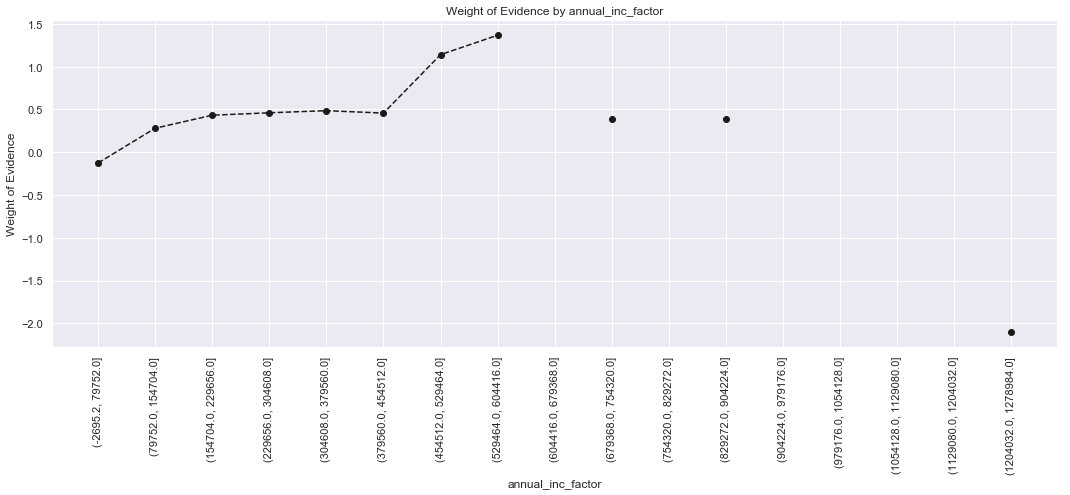

In [120]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [121]:
# Categories: Missing, 0-3, 4-30, 31-56, >=57
df_inputs_prepr['mths_since_last_delinq:Missing'] = np.where((df_inputs_prepr['mths_since_last_delinq'].isnull()), 1, 0)
df_inputs_prepr['mths_since_last_delinq:0-3'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 0) & (df_inputs_prepr['mths_since_last_delinq'] <= 3), 1, 0)
df_inputs_prepr['mths_since_last_delinq:4-30'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 4) & (df_inputs_prepr['mths_since_last_delinq'] <= 30), 1, 0)
df_inputs_prepr['mths_since_last_delinq:31-56'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 31) & (df_inputs_prepr['mths_since_last_delinq'] <= 56), 1, 0)
df_inputs_prepr['mths_since_last_delinq:>=57'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 57), 1, 0)

### Preprocessing Continuous Variables: Creating Dummy Variables, Part 3: Homework

In [122]:
# dti
df_inputs_prepr['dti_factor'] = pd.cut(df_inputs_prepr['dti'], 100)
# Here we do fine-classing: using the 'cut' method, we split the variable into 100 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr, 'dti_factor', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.04, 0.4]",187,0.893048,0.002005,167.0,20.0,0.002010,0.001963,0.024033,NaN,NaN,0.038143
1,"(0.4, 0.8]",184,0.880435,0.001973,162.0,22.0,0.001950,0.002159,-0.101675,0.012613,0.125708,0.038143
2,"(0.8, 1.2]",223,0.892377,0.002391,199.0,24.0,0.002396,0.002355,0.017022,0.011942,0.118697,0.038143
3,"(1.2, 1.6]",255,0.905882,0.002734,231.0,24.0,0.002781,0.002355,0.166135,0.013506,0.149113,0.038143
4,"(1.6, 2.0]",315,0.892063,0.003378,281.0,34.0,0.003383,0.003337,0.013766,0.013819,0.152370,0.038143
5,"(2.0, 2.399]",324,0.913580,0.003474,296.0,28.0,0.003563,0.002748,0.259926,0.021517,0.246161,0.038143
6,"(2.399, 2.799]",366,0.918033,0.003925,336.0,30.0,0.004045,0.002944,0.317685,0.004453,0.057759,0.038143
7,"(2.799, 3.199]",442,0.907240,0.004740,401.0,41.0,0.004827,0.004024,0.182161,0.010793,0.135524,0.038143
8,"(3.199, 3.599]",484,0.933884,0.005190,452.0,32.0,0.005441,0.003140,0.549718,0.026644,0.367557,0.038143
9,"(3.599, 3.999]",563,0.902309,0.006037,508.0,55.0,0.006116,0.005397,0.124920,0.031575,0.424798,0.038143


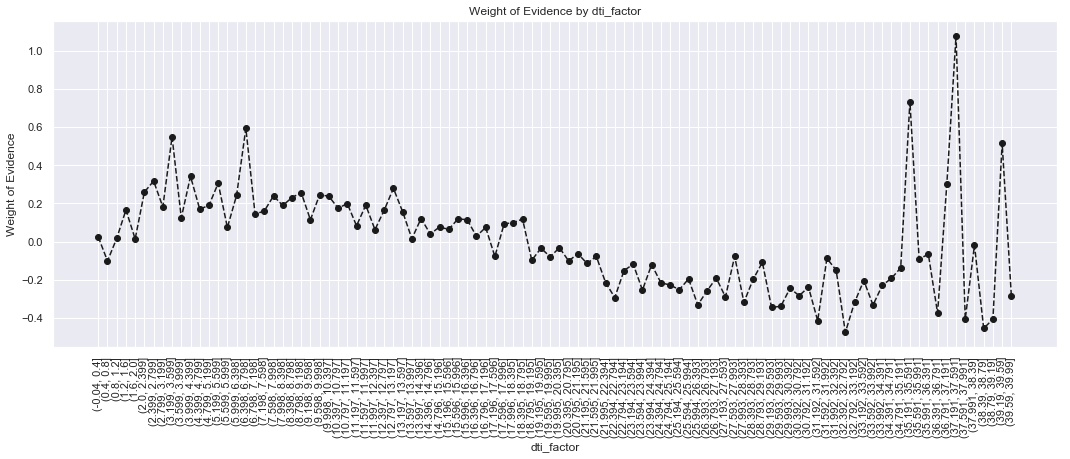

In [123]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [124]:
# Similarly to income, initial examination shows that most values are lower than 200.
# Hence, we are going to have one category for more than 35, and we are going to apply our approach to determine
# the categories of everyone with 150k or less.
df_inputs_prepr_temp = df_inputs_prepr.loc[df_inputs_prepr['dti'] <= 35, : ]

In [125]:
df_inputs_prepr_temp['dti_factor'] = pd.cut(df_inputs_prepr_temp['dti'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'dti_factor', df_targets_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
df_temp

C:\Users\kwaku\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


KeyError: "None of [Int64Index([362514, 288564, 213591, 263083, 165001,  82511,  24671,  97373,\n             44058, 351326,\n            ...\n             63372, 190559, 254758, 436344, 231767,    115, 296284,  61777,\n             91763, 167512],\n           dtype='int64', length=92548)] are in the [columns]"

In [ ]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [ ]:
# Categories:
df_inputs_prepr['dti:<=1.4'] = np.where((df_inputs_prepr['dti'] <= 1.4), 1, 0)
df_inputs_prepr['dti:1.4-3.5'] = np.where((df_inputs_prepr['dti'] > 1.4) & (df_inputs_prepr['dti'] <= 3.5), 1, 0)
df_inputs_prepr['dti:3.5-7.7'] = np.where((df_inputs_prepr['dti'] > 3.5) & (df_inputs_prepr['dti'] <= 7.7), 1, 0)
df_inputs_prepr['dti:7.7-10.5'] = np.where((df_inputs_prepr['dti'] > 7.7) & (df_inputs_prepr['dti'] <= 10.5), 1, 0)
df_inputs_prepr['dti:10.5-16.1'] = np.where((df_inputs_prepr['dti'] > 10.5) & (df_inputs_prepr['dti'] <= 16.1), 1, 0)
df_inputs_prepr['dti:16.1-20.3'] = np.where((df_inputs_prepr['dti'] > 16.1) & (df_inputs_prepr['dti'] <= 20.3), 1, 0)
df_inputs_prepr['dti:20.3-21.7'] = np.where((df_inputs_prepr['dti'] > 20.3) & (df_inputs_prepr['dti'] <= 21.7), 1, 0)
df_inputs_prepr['dti:21.7-22.4'] = np.where((df_inputs_prepr['dti'] > 21.7) & (df_inputs_prepr['dti'] <= 22.4), 1, 0)
df_inputs_prepr['dti:22.4-35'] = np.where((df_inputs_prepr['dti'] > 22.4) & (df_inputs_prepr['dti'] <= 35), 1, 0)
df_inputs_prepr['dti:>35'] = np.where((df_inputs_prepr['dti'] > 35), 1, 0)

In [126]:
# mths_since_last_record
# We have to create one category for missing values and do fine and coarse classing for the rest.
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_record'])]
#sum(loan_data_temp['mths_since_last_record'].isnull())
df_inputs_prepr_temp['mths_since_last_record_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_record'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = woe_ordered_continuous(df_inputs_prepr_temp, 'mths_since_last_record_factor', df_targets_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
df_temp

C:\Users\kwaku\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


KeyError: "None of [Int64Index([ 97373, 176798, 247866,  42139, 396449, 235420, 234504, 327472,\n            436296,  19587,\n            ...\n            450107,  72098, 328880, 427316,  39641, 242760, 138636, 398287,\n             46711, 251591],\n           dtype='int64', length=12571)] are in the [columns]"

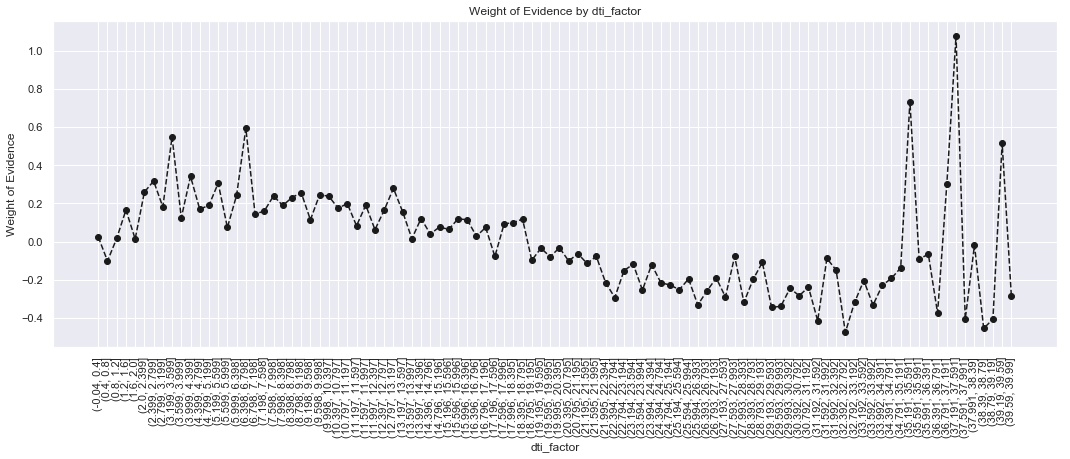

In [127]:
plot_by_woe(df_temp, 90)
# We plot the weight of evidence values.

In [128]:
# Categories: 'Missing', '0-2', '3-20', '21-31', '32-80', '81-86', '>86'
df_inputs_prepr['mths_since_last_record:Missing'] = np.where((df_inputs_prepr['mths_since_last_record'].isnull()), 1, 0)
df_inputs_prepr['mths_since_last_record:0-2'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 0) & (df_inputs_prepr['mths_since_last_record'] <= 2), 1, 0)
df_inputs_prepr['mths_since_last_record:3-20'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 3) & (df_inputs_prepr['mths_since_last_record'] <= 20), 1, 0)
df_inputs_prepr['mths_since_last_record:21-31'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 21) & (df_inputs_prepr['mths_since_last_record'] <= 31), 1, 0)
df_inputs_prepr['mths_since_last_record:32-80'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 32) & (df_inputs_prepr['mths_since_last_record'] <= 80), 1, 0)
df_inputs_prepr['mths_since_last_record:81-86'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 81) & (df_inputs_prepr['mths_since_last_record'] <= 86), 1, 0)
df_inputs_prepr['mths_since_last_record:>86'] = np.where((df_inputs_prepr['mths_since_last_record'] > 86), 1, 0)


### Preprocessing the Test Dataset

In [129]:
df_inputs_prepr.shape#(373028, 324)

(93257, 314)

In [130]:
df_inputs_prepr.isnull().sum()

NameError: name 'processed_loan_data_inputs' is not defined

### Assign Test Data Set to Be Equivalent to Processed Data Set

In [131]:
#after re runing, make
loan_data_inputs_test=df_inputs_prepr

In [132]:
df_inputs_prepr.isnull().sum()

Unnamed: 0.1                          0
id                                    0
member_id                             0
loan_amnt                             0
funded_amnt                           0
funded_amnt_inv                       0
term                                  0
int_rate                              0
installment                           0
grade                                 0
sub_grade                             0
emp_title                          5512
emp_length                         4200
home_ownership                        0
annual_inc                            0
verification_status                   0
issue_d                               0
loan_status                           0
pymnt_plan                            0
url                                   0
desc                              68194
purpose                               0
title                                 1
zip_code                              0
addr_state                            0


##### Review of Training Data Set

In [ ]:
list(loan_data_inputs_train.columns.values) 

In [182]:
#loan_data_inputs_train.isnull().sum()

In [180]:
loan_data_inputs_train.shape # should have same shape as processed data

(373028, 324)

In [179]:
df_inputs_prepr.shape

(373028, 324)

#### Save Test Data Set to CSV Format

In [133]:
loan_data_inputs_test.to_csv('loan_data_inputs_test.csv')
loan_data_targets_test.to_csv('loan_data_targets_test.csv')


#### Save Processed Data Seto to Be used for Making Test Data Set

In [181]:
df_inputs_prepr.to_csv('df_inputs_prepr')
df_targets_prepr.to_csv('df_targets_prepr')

C:\Users\kwaku\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


#### Save The Split Test Data to to Be Treated to Match Processed Data

In [177]:
loan_data_inputs_test.to_csv('loan_data_inputs_test')
loan_data_targets_test.to_csv('loan_data_targets_test')

C:\Users\kwaku\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [ ]:
loan_data_targets_test.shape #to be fixed

In [ ]:
loan_data_targets_test.shape #to be fixed

In [ ]:
loan_data_inputs_train.shape
# must be (373028,324)